In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb  4 13:48:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version 
!pip install mxnet-cu110   
!pip install --upgrade gluoncv
!pip install decord

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
     |████████████████████████████████| 325.4 MB 30 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.3 MB 14.3 MB/s 
     |████████████████████████████████| 13.6 MB 10.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np

import pandas
from decord import VideoReader

import mxnet as mx
import gluoncv 
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
import gluoncv.data 
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


Took below code from 7. Fine-tuning SOTA video models on your own dataset
(but changed the transform function to the one from 6. Dive Deep into Training SlowFast mdoels on Kinetcis400)

TRAIN DATA GENRATOR


In [ ]:
#https://medium.com/apache-mxnet/gluoncv-0-6-embrace-video-understanding-49bc10ec1421

num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.9]), #WAS THIS  scale_ratios=[1.0, 0.875, 0.75, 0.66]
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
    #video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size = 16 #change batch size over here 
num_workers = 0 # these two lines are used if we were trying to use multiple gpus - so ignore
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/sl_videos/'),#bounded_videos/'),
                               setting=os.path.expanduser('/content/drive/MyDrive/sl_videos/new_train.txt'),  #CHANGE
                               train=True,
                               video_loader=True,
                               use_decord=True,
                               new_step =2 ,
                               new_length=32,
                               transform=transform_train
                               )
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 1987 training samples.


VAL DATA GENERATOR


In [ ]:
#https://medium.com/apache-mxnet/gluoncv-0-6-embrace-video-understanding-49bc10ec1421

num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

transform_train = transforms.Compose([
    # Fix the input video frames size as 256×340 and randomly sample the cropping width and height from
    # {256,224,192,168}. After that, resize the cropped regions to 224 × 224.
    video.VideoMultiScaleCrop(size=(224, 224), scale_ratios=[1.0, 0.9]), #WAS THIS  scale_ratios=[1.0, 0.875, 0.75, 0.66]
    # Randomly flip the video frames horizontally
    video.VideoRandomHorizontalFlip(),
    # Transpose the video frames from height*width*num_channels to num_channels*height*width
    # and map values from [0, 255] to [0,1]
    video.VideoToTensor(),
    # Normalize the video frames with mean and standard deviation calculated across all images
   # video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

per_device_batch_size =16 #change batch size over here 
num_workers = 0 # these two lines are used if we were trying to use multiple gpus - so ignore
batch_size = per_device_batch_size * num_gpus

val_dataset = VideoClsCustom(root=os.path.expanduser('/content/drive/MyDrive/sl_videos/'),#bounded_videos/'),
                               setting=os.path.expanduser('/content/drive/MyDrive/sl_videos/new_val.txt'),  #CHANGE
                               train=False,
                               video_loader=True,
                               use_decord=True,
                               new_step =2 ,
                               new_length=32,
                               transform=transform_train
                               )


print('Load %d training samples.' % len(val_dataset))
val_data = gluon.data.DataLoader(val_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 353 training samples.


will get erroe if you set pretrained = true. Instead you should set pretrained_base = true as we are changing the number of classes 

In [ ]:
# kinetics_model = get_model(name='i3d_nl5_resnet50_v1_kinetics400', nclass=400, pretrained=True)
net = get_model(name='i3d_nl5_resnet50_v1_kinetics400',nclass=50,pretrained=False,pretrained_base=False,feat_ext=False,partial_bn=True)
# source_params = kinetics_model.collect_params()
# target_params = net.collect_params()
# assert len(source_params.keys()) == len(target_params.keys())

# pretrained_weights=[]
# for layer_name in source_params.keys():
#     pretrained_weights.append(source_params[layer_name].data())

# for i, layer_name in enumerate(target_params.keys()):
#     if i + 2 == len(source_params.keys()):
#         # skip the last dense layer
#         break
#     target_params[layer_name].set_data(pretrained_weights[i])

net.collect_params().reset_ctx(mx.Context('cpu'))
net.load_parameters('/content/drive/MyDrive/i3d_nl5_resnet50_v1_kinetics400/i3dnlres50/i3dnlres50_1_epoch_15')
net.collect_params().reset_ctx(mx.Context('gpu'))
net.collect_params().reset_ctx(ctx)

In [ ]:
#mx.viz.plot_network(net(mx.sym.var('data'))[0], node_attrs={"shape":"oval","fixedsize":"false"},hide_weights=False,save_format='pdf').render()

In [ ]:
net.summary

<bound method Block.summary of I3D_ResNetV1(
  (first_stage): HybridSequential(
    (0): Conv3D(3 -> 64, kernel_size=(5, 7, 7), stride=(2, 2, 2), padding=(2, 3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool3D(size=(1, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  )
  (pool2): MaxPool3D(size=(2, 1, 1), stride=(2, 1, 1), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (res_layers): HybridSequential(
    (0): HybridSequential(
      (0): Bottleneck(
        (bottleneck): HybridSequential(
          (0): Conv3D(64 -> 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
          (2): Activation(relu)
          (3): Conv3D(64 -> 64, k

In [ ]:
net.collect_params().setattr('grad_req', 'null')
net.res_layers[2].collect_params().setattr('grad_req', 'write')
net.res_layers[3].collect_params().setattr('grad_req', 'write')
net.st_avg.collect_params().setattr('grad_req', 'write')
net.head.collect_params().setattr('grad_req', 'write')
net.fc.collect_params().setattr('grad_req', 'write')

In [ ]:
net.hybridize()
warmup_epoch = 20
total_epoch = 75
num_batches = len(train_data)

scheduler =mx.lr_scheduler.CosineScheduler(max_update=total_epoch, base_lr=1e-4, final_lr=1e-6, warmup_steps=warmup_epoch,  warmup_mode='linear',warmup_begin_lr=1e-4)
optimizer = 'Adam'#mxnet.optimizer.Adam(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, )
# Set parameters
#optimizer_params = {'learning_rate':  0.005}  #,'wd': 0.0001, 'momentum': 0.9}
#optimizer_params['lr_scheduler'] = lr_scheduler
optimizer_params = {'wd': 1e-4}  #,'wd': 0.0001,

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)#the set of parameters to optimize
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
train_metric = mx.metric.Accuracy()
val_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc']) 

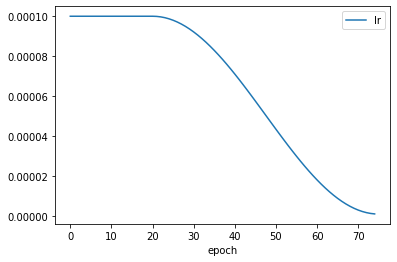

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['epoch','lr'])
for i in range(total_epoch):
  dictionary = {'epoch':i,'lr':scheduler(i)}
  df = df.append(dictionary,ignore_index=True)
df.plot(x = 'epoch', y = 'lr')


valid_acc = metric.Accuracy()
for data,label in valid_data:
    output = network(data)
    valid_acc.update(label,output)

In [ ]:
epochs = total_epoch

for epoch in range(epochs):
    lr = scheduler(epoch)
    trainer.set_learning_rate(lr)
    tic = time.time()
    train_metric.reset()
    val_metric.reset()
    train_loss = 0

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        #if i == 100:
         #   break

    name, acc = train_metric.get()

    #--------------------------------------------------------------------------
    for i, batch in enumerate(val_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        
        val_output = []
        for _, X in enumerate(data):
            X = X.reshape((-1,) + X.shape[2:])
            pred = net(X)
            val_output.append(pred)
            
   
        val_metric.update(label, val_output)
    name_val, val_acc = val_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f val=%f loss=%f lr=%f time: %f' %
        (epoch, acc, val_acc, train_loss / (i+1),trainer.learning_rate, time.time()-tic))
    
    if epoch%5==0:
      file_name = '/content/drive/MyDrive/i3d_nl5_resnet50_v1_kinetics400/i3dnlres50/i3dnlres50_4secondtry_epoch_'+str(epoch)
      net.save_parameters(file_name)
# We can plot the metric scores with:
train_history.plot()


[Epoch 0] train=0.510317 val=0.628895 loss=12.451263 lr=0.000100 time: 1354.344388
[Epoch 1] train=0.740312 val=0.705382 loss=4.646672 lr=0.000100 time: 421.752964
[Epoch 2] train=0.811777 val=0.708215 loss=3.198168 lr=0.000100 time: 422.610981
[Epoch 3] train=0.856568 val=0.719547 loss=2.526166 lr=0.000100 time: 424.006567
[Epoch 4] train=0.890790 val=0.770538 loss=1.722657 lr=0.000100 time: 422.797879
[Epoch 5] train=0.898339 val=0.736544 loss=1.728150 lr=0.000100 time: 421.770709
[Epoch 6] train=0.928032 val=0.762040 loss=1.286995 lr=0.000100 time: 424.643880
[Epoch 7] train=0.917967 val=0.781870 loss=1.356334 lr=0.000100 time: 424.121970
[Epoch 8] train=0.947660 val=0.753541 loss=0.959504 lr=0.000100 time: 424.547592
[Epoch 9] train=0.946653 val=0.796034 loss=0.917671 lr=0.000100 time: 424.981571
[Epoch 10] train=0.937594 val=0.770538 loss=1.261896 lr=0.000100 time: 426.250147
[Epoch 11] train=0.938098 val=0.776204 loss=1.030721 lr=0.000100 time: 428.196226
[Epoch 12] train=0.95218